In [130]:
AoI_csv_dir = 'input/aoi_ids.csv'
label_csv_dir = 'input/labels.csv'
features_csv_dir = 'processing/features_table.csv'
BAG_Panden = '/home/data/citycentre/BAG_Panden.shp'

# Dependencies

In [131]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time
#from PIL import Image
import pandas as pd
from shutil import copyfile
import matplotlib.image as mpimg
import numpy
import geopandas as gpd
import fiona
import rasterio
import rasterio.mask
from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from time import time
from scipy.stats import randint
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture
from sklearn.svm import LinearSVC
from sklearn.cluster import MeanShift
from sklearn.manifold import LocallyLinearEmbedding
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from shapely.geometry import shape
from shapely.geometry import Polygon
import shapefile
import shutil
import os
import glob

# Functions

In [132]:
def ids_to_shp_visualization(ids_list, directory, name, shape_file=BAG_Panden):

    i=0
    if not os.path.exists(directory+"/temporary"):
        os.makedirs(directory+"/temporary")
    
    for identifica in ids_list:
        for feat in fiona.open(shape_file, "r"):
            if identifica==feat['properties']['Identifica']:
                try:
                
                    feat2=feat['properties']['Identifica']
                    feat1=[feat['geometry']]
                    area_per_roof = feat['properties']['SHAPE_Area']

                    with fiona.open(shape_file, "r") as shapef:
                        meta=shapef.meta
                    with fiona.open(directory+'/temporary/'+str(i)+'.shp', 'w', **meta) as sink:
                            sink.write(feat)
    
                    i=i+1
                    #if i==1:
                    #    break
                except ValueError:
                    continue
    
    files = glob.glob(directory+"/temporary/*.shp")
    w = shapefile.Writer()
    for f in files:
            r = shapefile.Reader(f)
            w._shapes.extend(r.shapes())
            w.records.extend(r.records())
    w.fields = list(r.fields)
    w.save(directory+"/"+name+".shp")
    shutil.rmtree(directory+"/temporary/")
    

# Model

In [133]:
aoi_list = []
[aoi_list.append(ID) for ID in pd.read_csv(AoI_csv_dir, dtype=str).ID]
print('The IDs have been added.')

The IDs have been added.


In [134]:
label_df = pd.read_csv(label_csv_dir, dtype={'ID':str}).set_index('ID')
label_df.label = label_df.label.replace(3,2)
label_df.shape

(340, 1)

In [135]:
features_df = pd.read_csv(features_csv_dir, dtype={'ID':str}).set_index('ID')
features_df.loc(['0599100010050372'])

In [136]:
features_with_label = pd.concat([features_df, label_df], axis=1)


In [137]:
# Split-out validation dataset

X_train = features_with_label.loc[label_df.index].drop('label', 1).dropna()
y_train = features_with_label.loc[label_df.index].dropna().label
X_test = features_with_label.loc[aoi_list].drop('label', 1).dropna()

#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)

In [138]:
#y_train.head()

In [139]:
seed = 0
scoring = 'accuracy'

In [140]:
models = []
models.append(('GBC', GradientBoostingClassifier()))
models.append(('LR', LogisticRegression()))
models.append(('NB', GaussianNB()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('SVM', SVC()))
models.append(('SGD', SGDClassifier()))
models.append(('LSVM', LinearSVC()))

GBC: 0.855663 (0.086274)
LR: 0.826295 (0.099712)
NB: 0.802766 (0.116554)


/opt/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:455: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/opt/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/opt/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.808472 (0.103322)
KNN: 0.811326 (0.071435)
CART: 0.761062 (0.078024)
SVM: 0.606936 (0.179698)
SGD: 0.381080 (0.125629)
LSVM: 0.596971 (0.237643)


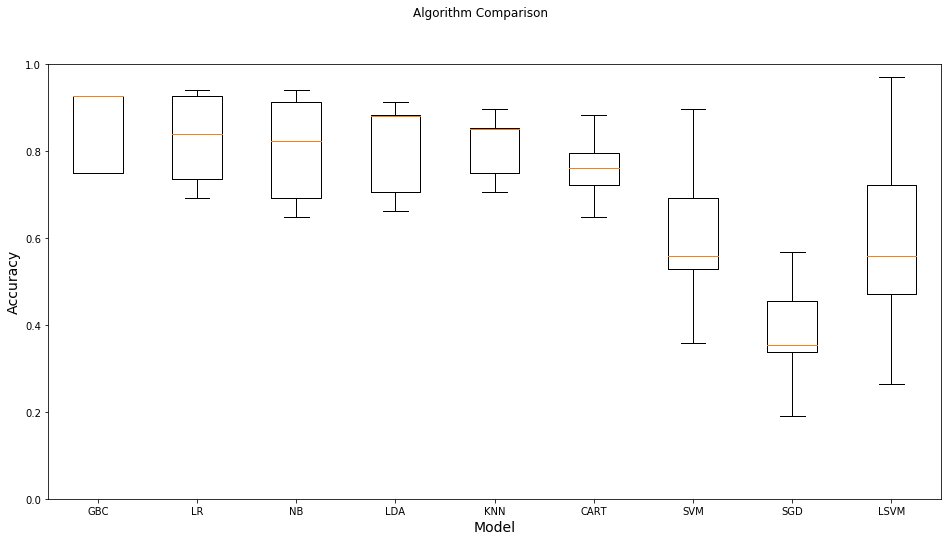

In [141]:
cv_results_mean = []
cv_results_std = []
results = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=seed)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    cv_results_mean.append(cv_results.mean())
    cv_results_std.append(cv_results.std())
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)


fig = plt.figure(figsize=(16, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.ylim([0,1])
plt.boxplot(results)
ax.set_xticklabels(names)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [142]:
clf = LogisticRegression()
model_train = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test).tolist()

#print(accuracy_score(y_test, y_pred))
#print(confusion_matrix(y_test, y_pred))
#print(classification_report(y_test, y_pred))
pred_proba = clf.predict_proba(X_test)
proba = clf.fit(X_train, y_train).predict_proba(X_test)

In [143]:
 model_aoi_ids = pd.DataFrame(y_pred_proba, index=X_test.index,\
                                columns=['nonveg_pred_proba', \
                                'green_pred_proba', 'tree_pred_proba'])

# AoI IDs Table

In [144]:
model_aoi_ids['probability'] = model_aoi_ids[['nonveg_pred_proba','green_pred_proba',\
                                'tree_pred_proba']].max(axis=1)
model_aoi_ids.loc[(model_aoi_ids.probability == model_aoi_ids.nonveg_pred_proba, 'classification')] = '1'
model_aoi_ids.loc[(model_aoi_ids.probability == model_aoi_ids.green_pred_proba, 'classification')] = '2'
model_aoi_ids.loc[(model_aoi_ids.probability == model_aoi_ids.tree_pred_proba, 'classification')] = '4'

model_aoi_ids.loc[(model_aoi_ids.classification == '1', 'category')] = 'Non-Vegetation'
model_aoi_ids.loc[(model_aoi_ids.classification == '2', 'category')] = 'Vegetation'
model_aoi_ids.loc[(model_aoi_ids.classification == '4', 'category')] = 'Trees'

In [145]:
output_model_aoi_ids = pd.concat([model_aoi_ids, features_with_label.loc[X_test.index]], axis=1, join='inner')

In [146]:
output_model_aoi_ids.loc[(output_model_aoi_ids['category'] == 'Non-Vegetation', 'area_interest')] = output_model_aoi_ids['total_area']
output_model_aoi_ids.loc[(output_model_aoi_ids['category'] == 'Vegetation', 'area_interest')] = output_model_aoi_ids['area_2_02']
output_model_aoi_ids.loc[(output_model_aoi_ids['category'] == 'Trees', 'area_interest')] = output_model_aoi_ids['total_area']

# AoI Summary Table

In [147]:
sum_value = output_model_aoi_ids.loc[output_model_aoi_ids['classification'] == 2].area_2_01.sum()

In [148]:
model_aoi_summary = output_model_aoi_ids.groupby(['category'])[['category']].count()
model_aoi_summary = model_aoi_summary.rename(columns={'category':'building_count'})
model_aoi_summary['building_pc'] = model_aoi_summary.building_count/np.sum(model_aoi_summary.building_count)
model_aoi_summary['area_sum'] = output_model_aoi_ids.groupby(['category'])[['area_interest']].sum()
model_aoi_summary.set_value('Non-Vegetation', 'area_sum', model_aoi_summary.iloc[0].area_sum + sum_value)
model_aoi_summary['area_pc'] = model_aoi_summary.area_sum/np.sum(model_aoi_summary.area_sum)
output_model_aoi_summary = model_aoi_summary

## Visualization

In [149]:
nonveg_id = []
veg_id = []
tree_id = []

[nonveg_id.append(i) for i in model_aoi_ids.loc[(model_aoi_ids.classification == '1', 'category')].index]
[veg_id.append(i) for i in model_aoi_ids.loc[(model_aoi_ids.classification == '2', 'category')].index]
[tree_id.append(i) for i in model_aoi_ids.loc[(model_aoi_ids.classification == '4', 'category')].index]
print("We now have a list of the IDS for each shapefile.")

We now have a list of the IDS for each shapefile.


# Output

In [150]:
ids_to_shp_visualization(nonveg_id, 'output', 'nonvegetation')
ids_to_shp_visualization(veg_id, 'output', 'vegetation')
ids_to_shp_visualization(tree_id, 'output', 'trees')

In [151]:
output_model_aoi_ids.to_csv('output/output_model_aoi_ids.csv')
model_aoi_summary.to_csv('output/output_model_aoi_summary.csv')